In [1]:
# Import all the functions you need
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
import os
from pathlib import Path

# Comment here to add in for either mac or linux computer
if os.environ['SHELL'] == '/bin/bash':   # for linux
    sys.path.extend(['/data/GitHub/NeuroPy']) 
    sys.path.extend(['/data/GitHub/TraceFC/'])
else:    # For mac laptop
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/TraceFC'])

from neuropy import core
from neuropy.io import (optitrackio,
                        dlcio,
                        )
from neuropy.io.neuroscopeio import NeuroscopeIO
from neuropy.io.binarysignalio import BinarysignalIO 
from neuropy.io.miniscopeio import MiniscopeIO
from neuropy.core import Epoch
from neuropy.utils import plot_util
from neuropy.utils.signal_process import WaveletSg
from neuropy.plotting.spikes import plot_raster, plot_binned_raster
from neuropy.plotting.signals import plot_signal_w_epochs, plot_spectrogram

from tracefc.io.session_directory import get_session_dir


In [2]:
# Define a class for a typical recording or set of recordings
class ProcessData:
    def __init__(self, basepath):
        basepath = Path(basepath)
        self.basepath = basepath
        xml_files = sorted(basepath.glob("*.xml"))
        assert len(xml_files) == 1, "Found more than one .xml file"
        
        fp = xml_files[0].with_suffix("")
        self.filePrefix = fp
        
        self.recinfo = NeuroscopeIO(xml_files[0])
        eegfiles = sorted(basepath.glob('*.eeg'))
        assert len(eegfiles) == 1, "Fewer/more than one .eeg file detected"
        self.eegfile = BinarysignalIO(eegfiles[0], n_channels=self.recinfo.n_channels,
                                     sampling_rate=self.recinfo.eeg_sampling_rate,
                                     )
        try:
            self.datfile = BinarysignalIO(eegfiles[0].with_suffix('.dat'),
                                         n_channels=self.recinfo.n_channels,
                                         sampling_rate=self.recinfo.dat_sampling_rate,
                                         )
        except FileNotFoundError:
            print('No dat file found, not loading')
                
        
    def __repr__(self) -> str:
        return f"{self.__class__.__name__}({self.recinfo.source_file.name})"
    
def sess_use(basepath=os.getcwd()):

    return ProcessData(basepath)

In [3]:
animal, sess_name = 'Finn', 'recall2'
sess_dir = get_session_dir(animal, sess_name)
sess = sess_use(sess_dir)
print(sess.recinfo)

No dat file found, not loading
filename: /data/Working/Trace_FC/Recording_Rats/Finn/2022_01_22_recall2/Finn_recall2_denoised.xml 
# channels: 35
sampling rate: 30000
lfp Srate (downsampled): 1250



In [4]:
print(sess.eegfile)

duration: 4636.13 seconds 
duration: 1.29 hours 



# Preprocess Ephys data
Identify artifacts:  
- disconnects  
- filtering  
  
Send to event files to check in Neuroscope  
Write `dead_times.txt` file for spyking-circus and `artifacts.npy` file for my own analysis.

### Identify disconnect and motion artifacts

In [5]:
from neuropy.analyses.artifact import detect_artifact_epochs
signal = sess.eegfile.get_signal()
buffer_add = 0.1  # seconds, None = don't add

art_epochs_file = sess.filePrefix.with_suffix(".art_epochs.npy")
if art_epochs_file.exists():
    art_epochs = Epoch(epochs=None, file=art_epochs_file)
    print('Existing artifact epochs file loaded')
else:
    art_epochs = detect_artifact_epochs(signal, thresh=6, 
                                    edge_cutoff=3, merge=6)

    if buffer_add is not None:  # Add in buffer to prevent erroneous detection of start/stop of artifact as SWRs
        art_epochs.add_epoch_buffer(buffer_add)
    sess.recinfo.write_epochs(epochs=art_epochs, ext='art')
    art_epochs.save(art_epochs_file)
art_epochs

Existing artifact epochs file loaded


40 epochs
Snippet: 
       start      stop label
0   99.6064  123.6392      
1  130.9416  140.4024      
2  156.9208  162.9472      
3  201.2080  201.5040      
4  208.3872  210.3880      

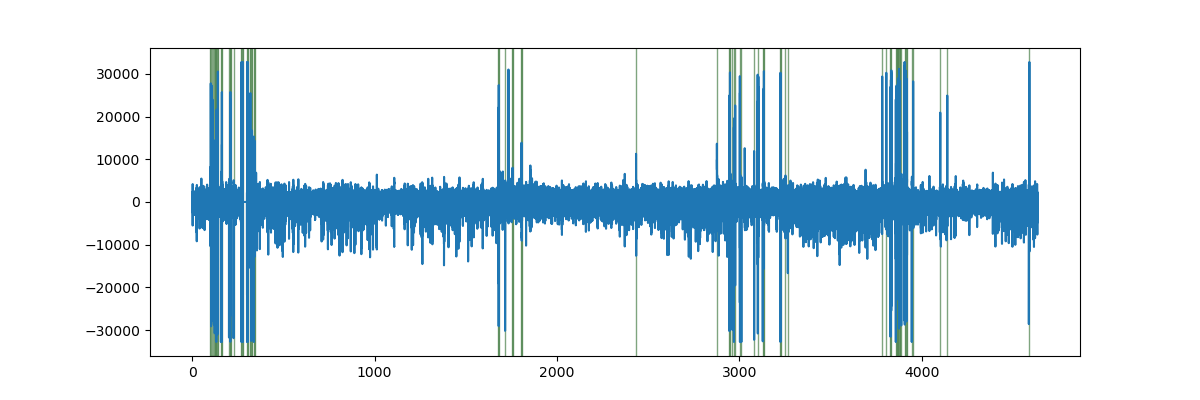

In [6]:
%matplotlib widget
_, ax = plt.subplots(figsize=(12, 4))
chan_plot = 28
ax.plot(signal.time, signal.traces[chan_plot])

for start, stop in zip(art_epochs.starts, art_epochs.stops):
    ax.axvspan(start, stop, color=[0, 0.3, 0, 0.5])


## Define probe group

/data/Working/Trace_FC/Recording_Rats/Finn/2022_01_22_recall2/Finn_recall2_denoised.probegroup.npy saved


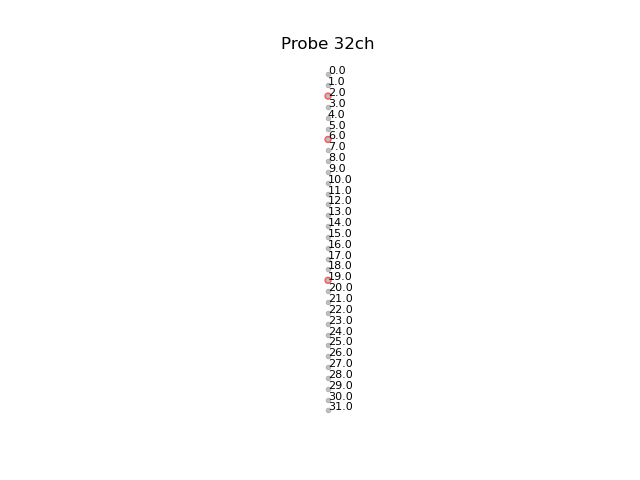

In [7]:
from neuropy.core import Shank, Probe, ProbeGroup
from neuropy.plotting import plot_probe
shank = Shank()
shank = shank.auto_generate(columns=1, contacts_per_column=32, xpitch=0,
                   ypitch=20, channel_id=np.arange(31, -1, -1))
shank.set_disconnected_channels(sess.recinfo.skipped_channels)
probe = Probe(shank)
prbgrp = ProbeGroup()
prbgrp.add_probe(probe)
plot_probe(prbgrp)
prbgrp.filename = sess.filePrefix.with_suffix(".probegroup.npy")
prbgrp.save(prbgrp.filename)
sess.prbgrp = prbgrp

# Detect Theta epochs

In [8]:
from neuropy.analyses.oscillations import detect_theta_epochs
mindur=0.25
maxdur=20
thresh = (0.5, None)
sigma = 0.125
edge_cutoff = 0.25
theta_channel = 31

# use this if you don't know theta channel
if theta_channel is None:
    theta_epochs, theta_power = detect_theta_epochs(signal, prbgrp, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)
else:
    signal_use = signal.time_slice(channel_id=theta_channel)
    theta_epochs, theta_power = detect_theta_epochs(signal_use, probegroup=None, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)

Best channel for theta: [31]
1979 epochs remaining with durations within (0.25,20)


## Detect SWR Epochs

In [9]:
from neuropy.analyses.oscillations import detect_ripple_epochs
ripple_channel = 25
thresh = (3, None)  # conservative but good
ripple_epochs = detect_ripple_epochs(signal, prbgrp, thresh=thresh, ripple_channel=ripple_channel, 
                                     ignore_epochs=art_epochs)


Selected channels for ripples: [25]
1009 epochs remaining with durations within (0.05,0.45)


# Wavelet Analysis

### Start with Theta

In [10]:
# Run wavelet on theta range
theta_range = np.arange(4, 14, 0.25)  # How do I select these? 0.25Hz seems good to start
wv_theta = WaveletSg(signal.time_slice(channel_id=theta_channel), freqs=theta_range, sigma=None)

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

<Axes: xlabel='Time (s)', ylabel='Frequency (Hz)'>

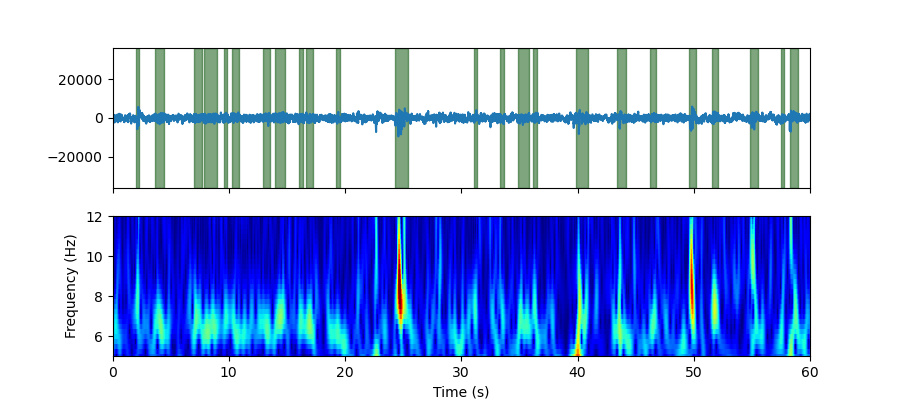

In [11]:
# Sanity check code - does wavelet align well with actual theta epochs?
_, ax = plt.subplots(2, 1, sharex=True, figsize=(9, 4))
time_to_plot = [0, 60]
theta_freq_lims = [5, 12]

plot_signal_w_epochs(signal, theta_channel, theta_epochs, ax=ax[0])

plot_spectrogram(wv_theta, time_lims=time_to_plot, freq_lims=theta_freq_lims, ax=ax[1])

### Mean spectrogram at theta starts

Events [1976 1977 1978] are outside of data range and were dropped


interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

Text(0.5, 0, 'Time from Theta epoch start (sec)')

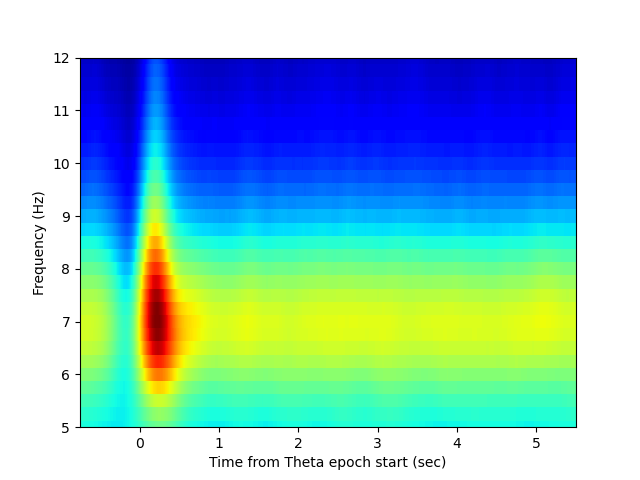

In [12]:
theta_buffer_sec = (0.75, 5.5)
wv_theta_mean = wv_theta.get_pe_mean_spec(theta_epochs.starts, buffer_sec=theta_buffer_sec)
ax = plot_spectrogram(wv_theta_mean, time_lims=np.multiply(theta_buffer_sec, (-1, 1)), freq_lims=theta_freq_lims)
ax.set_xlabel('Time from Theta epoch start (sec)')

### Try out SWRs

In [13]:
swr_range = np.arange(125, 275, 5)
wv_swr = WaveletSg(signal.time_slice(channel_id=ripple_channel), freqs=swr_range, sigma=None)

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

<Axes: xlabel='Time (s)', ylabel='Frequency (Hz)'>

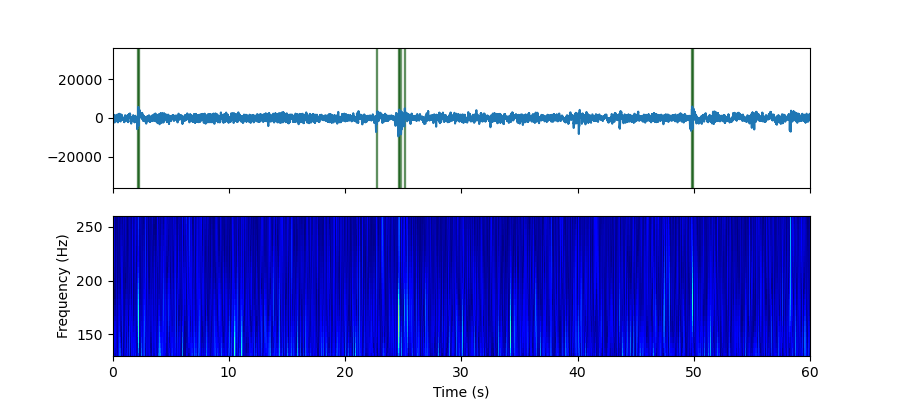

In [14]:
# Sanity check code - does wavelet align well with actual theta epochs?
_, ax = plt.subplots(2, 1, sharex=True, figsize=(9, 4))
time_to_plot = [0, 60]
swr_freq_lims = [130, 260]

plot_signal_w_epochs(signal, theta_channel, ripple_epochs, ax=ax[0])

plot_spectrogram(wv_swr, time_lims=time_to_plot, freq_lims=swr_freq_lims, ax=ax[1])

### Mean spectrogram at all ripples

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

Text(0.5, 0, 'Time from Ripple Peak (sec)')

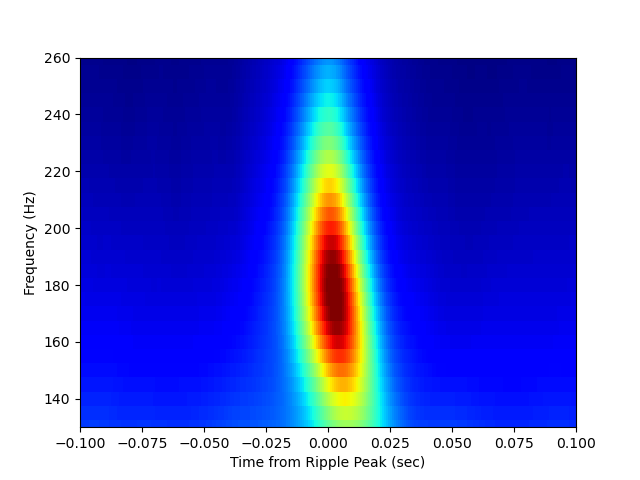

In [15]:
ripple_buffer_sec = (0.1, 0.1)
wv_swr_mean = wv_swr.get_pe_mean_spec(ripple_epochs.to_dataframe()['peak_time'].values, buffer_sec=ripple_buffer_sec)
ax = plot_spectrogram(wv_swr_mean, time_lims=np.multiply(ripple_buffer_sec, (-1, 1)), freq_lims=swr_freq_lims)
ax.set_xlabel('Time from Ripple Peak (sec)')

## Peri-CS analyses

,channel_states,timestamps,datetimes,event_name
0,-2,849444,2022-01-22 12:25:50.314800000,
906,2,5551671,2022-01-22 12:47:13.055700000,
1054,-2,5849302,2022-01-22 12:47:22.976733333,
2005,2,7769640,2022-01-22 12:48:26.988000000,
2153,-2,8067819,2022-01-22 12:48:36.927300000,


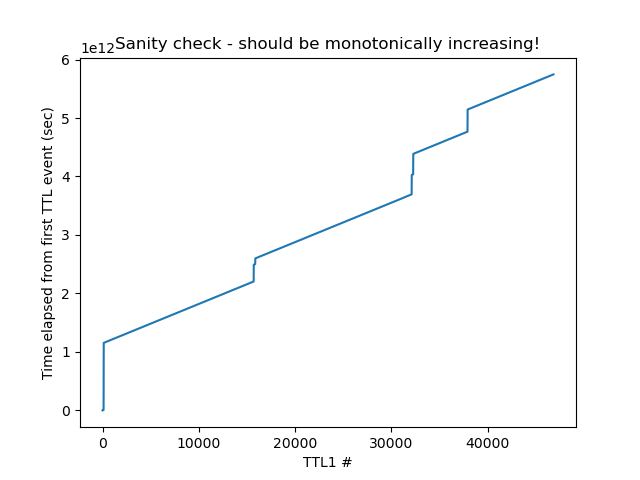

In [28]:
import neuropy.io.openephysio as oeio

# Import TTLs for CS from OpenEphys
ttl_df = oeio.load_all_ttl_events(sess.basepath, sanity_check_channel=1, zero_timestamps=True)
ttl_df[ttl_df['channel_states'].abs() == 2].head(5)

In [17]:
import tracefc.io.traceio as traceio
cs_starts, cs_ends, cs_df = traceio.load_trace_events(sess.basepath, session_type="tone_recall", 
                                                      event_type="CS+", return_df=True)
print(f'{cs_starts.shape[0]} CS+ events detected')
print(cs_starts.head(6))

csn_starts, csn_ends, csn_df = traceio.load_trace_events(sess.basepath, session_type="control_tone_recall", 
                                                      event_type="CS-", return_df=True)
print(f'{csn_starts.shape[0]} CS- events detected')
print(csn_starts.head(6))

15 CS+ events detected
      Time (s)      Event                     Timestamp
13   61.003838  CS1_start 2022-01-22 12:47:13.691847062
15  134.935588  CS2_start 2022-01-22 12:48:27.623596883
17  199.884599  CS3_start 2022-01-22 12:49:32.572607970
19  272.865102  CS4_start 2022-01-22 12:50:45.553110576
21  335.793413  CS5_start 2022-01-22 12:51:48.481422401
23  405.744088  CS6_start 2022-01-22 12:52:58.432096934
18 CS- events detected
      Time (s)      Event                     Timestamp
9    60.845767  CS1_start 2022-01-22 13:11:30.724150783
11  123.774616  CS2_start 2022-01-22 13:12:33.653000480
13  203.726303  CS3_start 2022-01-22 13:13:53.604687339
15  265.673500  CS4_start 2022-01-22 13:14:55.551883584
17  331.603791  CS5_start 2022-01-22 13:16:01.482175475
19  393.553503  CS6_start 2022-01-22 13:17:03.431886798


In [18]:
sync_df = oeio.create_sync_df(sess.basepath)
sync_df

start time = 2022-01-22 12:25:22.257986-05:00
start time = 2022-01-22 12:44:08.641035-05:00
start time = 2022-01-22 13:06:32.283185-05:00
start time = 2022-01-22 13:33:03.698817-05:00
start time = 2022-01-22 13:48:09.925495-05:00


,Recording,Datetime,Condition,nframe_dat,dat_time,nframe_eeg,eeg_time
0,0,2022-01-22 12:25:22.257986-05:00,start,0,0.000000,0,0.0000
1,0,2022-01-22 12:30:49.818486-05:00,stop,9826815,327.560500,409450,327.5600
2,1,2022-01-22 12:44:08.641035-05:00,start,9826816,327.560533,409451,327.5608
3,1,2022-01-22 13:04:33.490068333-05:00,stop,46572287,1552.409567,1940511,1552.4088
4,2,2022-01-22 13:06:32.283185-05:00,start,46572288,1552.409600,1940512,1552.4096
5,2,2022-01-22 13:28:36.613818333-05:00,stop,86302207,2876.740233,3595925,2876.7400
6,3,2022-01-22 13:33:03.698817-05:00,start,86302208,2876.740267,3595926,2876.7408
7,3,2022-01-22 13:46:50.732383667-05:00,stop,111113215,3703.773833,4629717,3703.7736
8,4,2022-01-22 13:48:09.925495-05:00,start,111113216,3703.773867,4629718,3703.7744
9,4,2022-01-22 14:03:42.277461667-05:00,stop,139083775,4636.125833,5795157,4636.1256


In [38]:
# Grab CS times corresponding to OE timestamps
ttl_lag_use = ttl_lag=pd.Timedelta(0.8, unit="seconds")
cs_oe_start_df = traceio.trace_ttl_to_openephys(cs_starts, 
                                  ttl_df[ttl_df['channel_states'].abs() == 2], 
                                  ttl_lag=ttl_lag_use)

csn_oe_start_df = traceio.trace_ttl_to_openephys(csn_starts, 
                                  ttl_df[ttl_df['channel_states'].abs() == 2], 
                                  ttl_lag=ttl_lag_use*2)

# Convert to times in combined eeg file
cs_starts_combined = oeio.recording_events_to_combined_time(cs_oe_start_df, sync_df)
csn_starts_combined = oeio.recording_events_to_combined_time(csn_oe_start_df, sync_df)

start time lag: mean = -0.6316320616, std = 0.007416420918518176
start time lag: mean = -0.39942909682352945, std = 0.20324386711252984


## Theta mean spectrogram

In [ ]:
from tracefc.plotting.signals import plot_cs_mean_wavelet

_, ax = plt.subplots(4, 1, figsize=(9, 8), height_ratios=[1, 5, 1, 5], layout='tight', sharex=True)

_, std_sxx = plot_cs_mean_wavelet(wv_theta, cs_starts_combined, 'CS+', buffer_sec=cs_buffer, freq_lims=theta_freq_lims,
                     ignore_epochs=art_epochs, ax=ax[:2])
plot_cs_mean_wavelet(wv_theta, csn_starts_combined, 'CS-', buffer_sec=cs_buffer, freq_lims=theta_freq_lims,
                     ignore_epochs=art_epochs, std_sxx=std_sxx, ax=ax[2:])

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

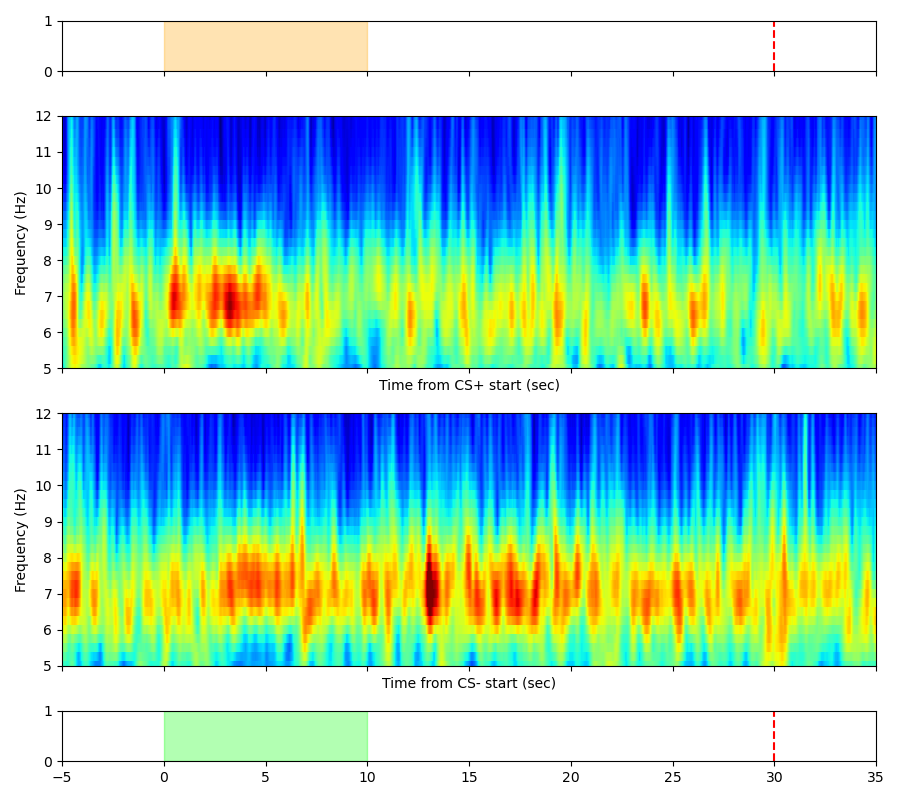

In [41]:
# Plot mean wavelet spectrogram at CS+ onset - compare to above!
cs_buffer = (5, 35)

wv_theta_cs_mean = wv_theta.get_pe_mean_spec(cs_starts_combined, buffer_sec=cs_buffer, ignore_epochs=art_epochs)
std_cs = np.std(wv_theta_cs_mean.traces)

_, ax = plt.subplots(4, 1, figsize=(9, 8), height_ratios=[1, 5, 5, 1], layout='tight', sharex=True)

plot_spectrogram(wv_theta_cs_mean, time_lims=np.multiply(cs_buffer, (-1, 1)), freq_lims=theta_freq_lims, ax=ax[1], std_sxx=std_cs)
ax[1].set_xlabel('Time from CS+ start (sec)')

wv_theta_csn_mean = wv_theta.get_pe_mean_spec(csn_starts_combined, buffer_sec=cs_buffer, ignore_epochs=art_epochs)
plot_spectrogram(wv_theta_csn_mean, time_lims=np.multiply(cs_buffer, (-1, 1)), freq_lims=theta_freq_lims, ax=ax[2], std_sxx=std_cs)
ax[2].set_xlabel('Time from CS- start (sec)')

# Add color keys to plots above/below
ax[0].axvspan(0, 10, color=[1, 0.647, 0, 0.3])
ax[3].axvspan(0, 10, color=[0, 1, 0, 0.3])
[a.axvline(30, color='r', linestyle='--') for a in (ax[0], ax[3])];
# [a.axis('off') for a in (ax[0], ax[3])];

## Ripple mean spectrogram

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

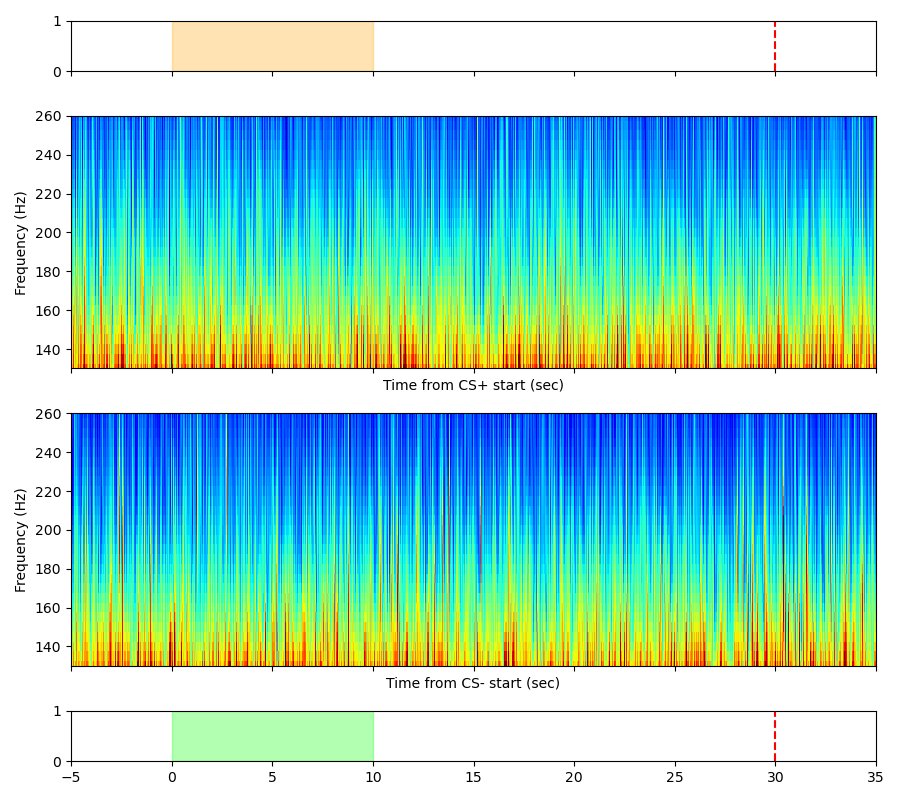

In [42]:
# Plot mean wavelet spectrogram at CS+ onset
cs_buffer = (5, 35)

### NRK todo: add in recording_events_to_combined_time function here! Or is is necessary?
wv_swr_cs_mean = wv_swr.get_pe_mean_spec(cs_starts_combined, buffer_sec=cs_buffer, ignore_epochs=art_epochs)

_, ax = plt.subplots(4, 1, figsize=(9, 8), height_ratios=[1, 5, 5, 1], layout='tight', sharex=True)

plot_spectrogram(wv_swr_cs_mean, time_lims=np.multiply(cs_buffer, (-1, 1)), freq_lims=swr_freq_lims, ax=ax[1])
ax[1].set_xlabel('Time from CS+ start (sec)')

wv_swr_csn_mean = wv_swr.get_pe_mean_spec(csn_starts_combined, buffer_sec=cs_buffer, ignore_epochs=art_epochs)
plot_spectrogram(wv_swr_csn_mean, time_lims=np.multiply(cs_buffer, (-1, 1)), freq_lims=swr_freq_lims, ax=ax[2])
ax[2].set_xlabel('Time from CS- start (sec)')

# Add color keys to plots above/below
ax[0].axvspan(0, 10, color=[1, 0.647, 0, 0.3])
ax[3].axvspan(0, 10, color=[0, 1, 0, 0.3])
[a.axvline(30, color='r', linestyle='--') for a in (ax[0], ax[3])];
# [a.axis('off') for a in (ax[0], ax[3])];

## Save notebook to working directory

In [23]:
from neuropy.utils.manipulate_files import save_notebook
save_notebook(sess.basepath, save_prepend=f"{animal}_{sess_name}_")

/data/GitHub/TraceFC/Notebooks/Spectral_Analysis.ipynb saved to /data/Working/Trace_FC/Recording_Rats/Finn/2022_01_22_recall2/Finn_recall2_Spectral_Analysis.ipynb
